In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

### Load the dataset

In [4]:
data = pd.read_csv('student-mat.csv',sep=";")
data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


## Data Preprocessing

### Check for missing values

In [7]:
print(data.isnull().sum())
# no missig values

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


### Define features and target variable

In [9]:
X=data.drop(['G3'],axis=1)
y=data['G3']

### Split the data into training and test sets

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

### Encode categorical variables

In [13]:
cat_col=X.select_dtypes(include=['object']).columns
num_col=X.select_dtypes(exclude=['object']).columns

### scaling for numerical data

In [15]:
num_trans=Pipeline(steps=[('scaler',StandardScaler())])

### Impute missing values and encode categories for categorical data

In [17]:
cat_trans=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))])

### Apply transformations

In [19]:
preprocess=ColumnTransformer(
    transformers=[
        ('num',num_trans,num_col),
        ('cat',cat_trans,cat_col)])
X_train_process=preprocess.fit_transform(X_train)
X_test_process=preprocess.transform(X_test)

### distribution of the final grades

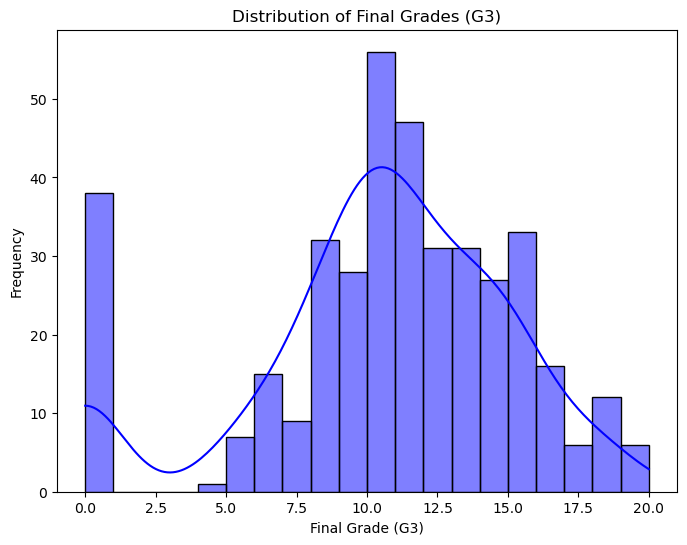

In [21]:
plt.figure(figsize=(8,6))
sns.histplot(y,kde=True,color="blue",bins=20)
plt.title("Distribution of Final Grades (G3)")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Frequency")
plt.show()

### heatmap of correlations

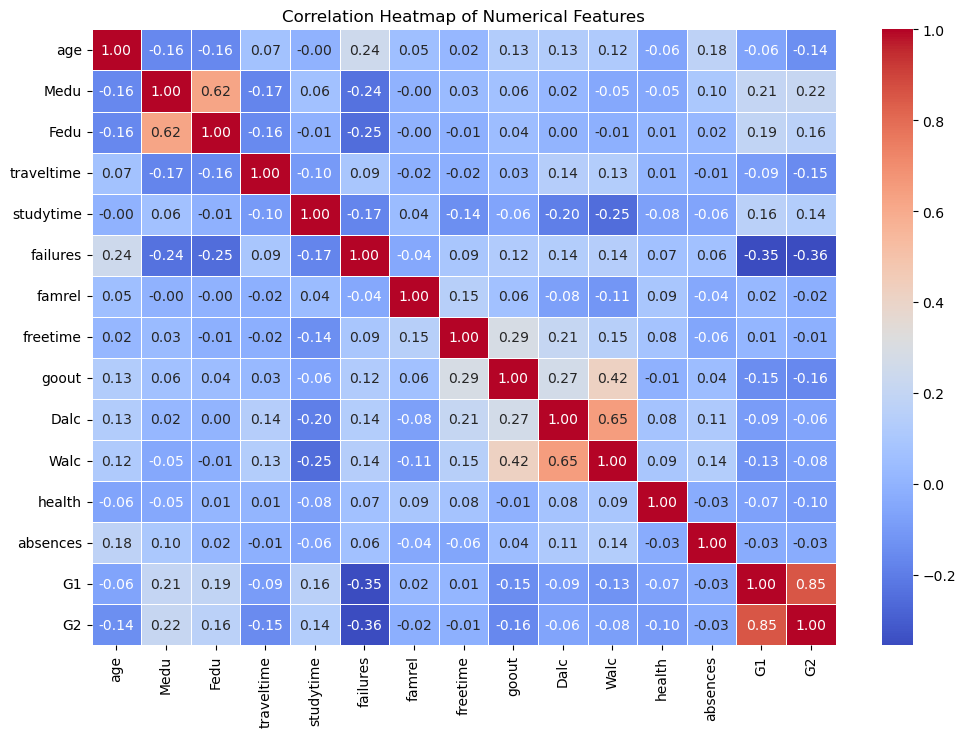

In [23]:
correlation_matrix=X[num_col].corr() # Compute the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix,annot=True,cmap="coolwarm",fmt=".2f",linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

## Step of forward, backward, and forward-backward regressions,together with k-fold cross-validation

In [25]:
X=pd.get_dummies(X,drop_first=True) # Convert to numeric
model = LinearRegression()
kf=KFold(n_splits=10,shuffle=True,random_state=42) # KFold cross-validation

### Forward Regression

In [27]:
def forward_selection(X,y):
    selected_features=[]
    remaining_features=list(X.columns)
    best_mse=float('inf')
    
    while remaining_features:
        mse_values=[]
        
        # Test adding each remaining feature one by one
        for feature in remaining_features:
            features_to_try = selected_features + [feature]
            mse = -cross_val_score(model, X[features_to_try], y, cv=kf, scoring='neg_mean_squared_error').mean()
            mse_values.append((mse, feature))
        
        # Select the feature with the lowest MSE
        mse_values.sort()
        best_mse_new, best_feature = mse_values[0]
        
        # Add the best feature to the model if it improves MSE
        if best_mse_new<best_mse:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_mse=best_mse_new
        else:
            break 
    
    return selected_features

### Backward Regression

In [29]:
def backward_elimination(X, y):
    selected_features = list(X.columns)
    best_mse = float('inf')
    
    while len(selected_features) > 1:
        mse_values = []
        
        # Test removing each feature one by one
        for feature in selected_features:
            features_to_try = [f for f in selected_features if f != feature]
            mse = -cross_val_score(model, X[features_to_try], y, cv=kf, scoring='neg_mean_squared_error').mean()
            mse_values.append((mse, feature))
        
        # Select the feature to remove
        mse_values.sort()
        best_mse_new, feature_to_remove = mse_values[0]
        
        # Remove the feature if MSE improves
        if best_mse_new < best_mse:
            selected_features.remove(feature_to_remove)
            best_mse = best_mse_new
        else:
            break  
    
    return selected_features

### Forward-Backward Regression

In [31]:
def stepwise_regression(X, y):
    selected_features=[]
    remaining_features=list(X.columns)
    best_mse=float('inf')
    
    # Forward Step
    while remaining_features:
        mse_values=[]
        
        for feature in remaining_features:
            features_to_try = selected_features + [feature]
            mse = -cross_val_score(model, X[features_to_try], y, cv=kf, scoring='neg_mean_squared_error').mean()
            mse_values.append((mse, feature))
        
        mse_values.sort()
        best_mse_new, best_feature = mse_values[0]
        
        if best_mse_new<best_mse:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_mse=best_mse_new
        else:
            break

    # Backward Step
    while len(selected_features)>1:
        mse_values=[]
        
        for feature in selected_features:
            features_to_try=[f for f in selected_features if f != feature]
            mse = -cross_val_score(model, X[features_to_try], y, cv=kf, scoring='neg_mean_squared_error').mean()
            mse_values.append((mse, feature))
        
        mse_values.sort()
        best_mse_new, feature_to_remove = mse_values[0]
        
        if best_mse_new<best_mse:
            selected_features.remove(feature_to_remove)
            best_mse=best_mse_new
        else:
            break
    
    return selected_features

## Run all three methods

### Forward Regression

In [34]:
features_forward=forward_selection(X,y)
print(f"Forward Selected Features:{features_forward}")

Forward Selected Features:['G2', 'famrel', 'absences', 'G1', 'age', 'reason_other', 'activities_yes', 'Fjob_services', 'Walc', 'Dalc', 'schoolsup_yes']


### Backward Regression

In [36]:
features_backward=backward_elimination(X,y)
print(f"Backward Selected Features:{features_backward}")

Backward Selected Features:['age', 'famrel', 'freetime', 'Dalc', 'Walc', 'absences', 'G1', 'G2', 'Fjob_health', 'reason_other', 'schoolsup_yes', 'activities_yes']


### Forward-Backward Regression

In [38]:
features_stepwise=stepwise_regression(X,y)
print(f"Forward-Backward Selected Features:{features_stepwise}")

Forward-Backward Selected Features:['G2', 'famrel', 'absences', 'G1', 'age', 'reason_other', 'activities_yes', 'Fjob_services', 'Walc', 'Dalc', 'schoolsup_yes']


### assess the models using k-fold cross-validation and calculate the mean squared error (MSE)

In [40]:
cv_forward=cross_val_score(model,X[features_forward],y,cv=kf,scoring='neg_mean_squared_error')
cv_backward=cross_val_score(model,X[features_backward],y,cv=kf,scoring='neg_mean_squared_error')
cv_stepwise=cross_val_score(model,X[features_stepwise],y,cv=kf,scoring='neg_mean_squared_error')

### Print MSE results

In [42]:
print(f"Mean Squared Error of Forward Regression: {-cv_forward.mean()} ± {cv_forward.std()}")
print(f"Mean Squared Error of Backward Regression: {-cv_backward.mean()} ± {cv_backward.std()}")
print(f"Mean Squared Error of Forward-Backward Regression: {-cv_stepwise.mean()} ± {cv_stepwise.std()}")

Mean Squared Error of Forward Regression: 3.518070272123919 ± 1.0608208443599574
Mean Squared Error of Backward Regression: 3.518433276445272 ± 1.1065481791747722
Mean Squared Error of Forward-Backward Regression: 3.518070272123919 ± 1.0608208443599574
